In [32]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

# **Обучение нейрона выполнению функции логического "ИЛИ"**

In [33]:
X = tf.constant([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tf.float32) # входные данные x1 и x2 (признаки, характеризующие объект)
Y = tf.constant([[0], [1], [1], [1]], dtype=tf.float32) # желаемый выход (метки классов для каждого объекта)

In [34]:
# Вспомогательная функция для отрисовки границы решения
def plot_decision_boundary(model, X, y):

  # Определются границы рассматриваемого пространства (минимальный и максимальный x и y) и создаётся его сетка meshgrid
  X = X.numpy()
  y = y.numpy()
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx1, xx2 = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

  # Создаются входные сигналы X (мы собираемся предсказывать значения по всей сетке рассматриваемого пространства)
  x_in = np.c_[xx1.ravel(), xx2.ravel()] # соединяем 2D массивы вместе: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Осуществляется предсказание для входных сигналов X
  y_pred = model.predict(x_in, batch_size=1024)
  y_pred = np.round(np.max(y_pred, axis=-1)).reshape(xx1.shape) # reshape необходим поскольку результатом будет 1D вектор, а необходим 2D, как у xx1

  # Визуализация границ решения
  plt.contourf(xx1, xx2, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.pause(0.01)

# Вспомогательный колбэк для отрисовки границы решений каждые 100 эпох и остановки обучения если точность достигла 1.0
class PlotAndStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Отрисовываем каждые 100 эпох
            print(f"Epoch {epoch + 1}")
            plot_decision_boundary(self.model, X, Y)

        if logs.get('accuracy') == 1.0:  # Остановка, если точность достигла 1.0
            print(f"\nStopping training at epoch {epoch + 1} as accuracy reached 1.0")
            plot_decision_boundary(self.model, X, Y)
            self.model.stop_training = True

In [35]:
###### Основной код ######

def createModel(input_shape):
  input_x = Input(shape=(input_shape, )) # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  z = Dense(1)(input_x) # создаём 1 нейрон и передаём в него входные сигналы input_x
  p = Activation('sigmoid')(z) # результат обработки нейроном входных сигналов z поступает в сигмоидальную функцию активации, которая выдаёт вероятность принадлежности к классу 1
  return Model(inputs=input_x, outputs=p) # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X, Y):
  model = createModel(2) # создаётся модель принимающая на вход входные сигналы с размерностью 2
  #  Компилируется модель, задаётся оптимизатор sgd - стохастический градиентный спуск (алгоритм минимизирующий функцию ошибки), можно ещё попробовать: adam, rmsprop
  #                       задаётся функция ошибки loss бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
  #                       задаётся метрика Accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary() # вывод информации о созданной модели
  callback = PlotAndStopCallback() # используем колбэк для отрисовки
  model.fit(x=X, y=Y, epochs=5000, callbacks=[callback]) # вызывается метод обучения, принимающий на вход X, Y и количество эпох обучения
  return model # обученная модель возвращается для тестирования и других манипуляций

def testModel(X_test, model):
  result = model.predict(X_test) # вызывается метод предсказания для входных тестовых данных
  print(result)
  # Задаётся решающее правило.
  if(result >= 0.5): # если выходная вероятность предсказания больше или равно 0.5 то возвращаем класс 1
    return 1
  elif(result < 0.5): # если выходная вероятность предсказания меньше 0.5 то возвращаем класс 0
    return 0

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5000 - loss: 0.8554
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.8546
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.8537
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.8528
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.8519
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.8510
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.8502
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.8493
Epoch 9/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.8484
Epoch 10/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.8475
Epoch 11/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.8467
Epoch 12/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy

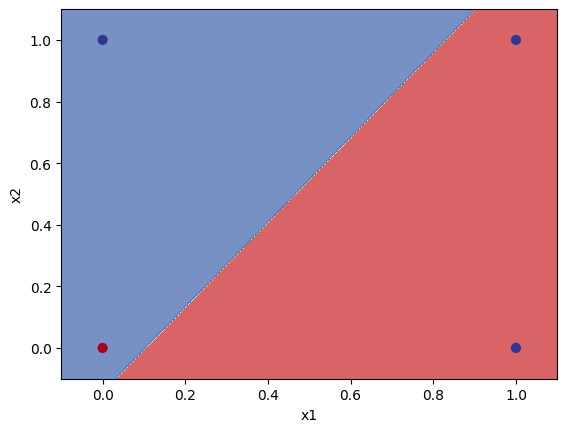

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.2500 - loss: 0.7747
Epoch 101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7740
Epoch 102/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.7733
Epoch 103/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7725
Epoch 104/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7718
Epoch 105/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.7710
Epoch 106/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7703
Epoch 107/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.7696
Epoch 108/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7688
Epoch 109/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.7681
Epoch 110/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.7674
Epoch 111/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - ac

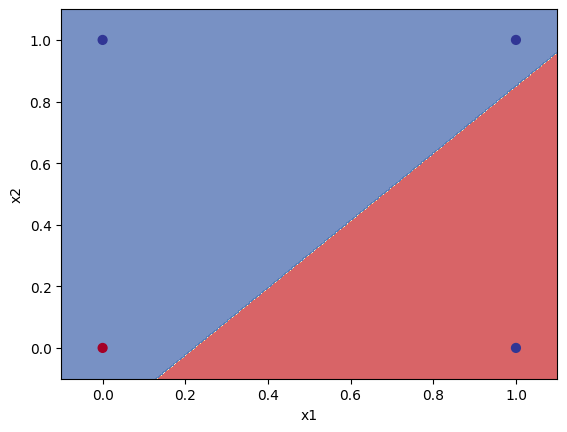

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5000 - loss: 0.7072
Epoch 201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7066
Epoch 202/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 203/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7054
Epoch 204/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7048
Epoch 205/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.7042
Epoch 206/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7036
Epoch 207/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7030
Epoch 208/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 209/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7018
Epoch 210/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7012
Epoch 211/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - ac

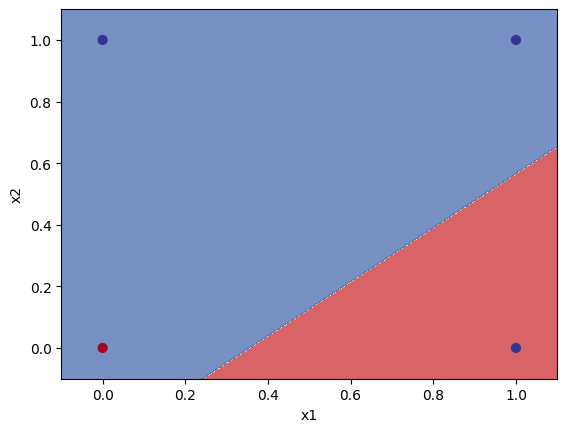

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5000 - loss: 0.6521
Epoch 301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6516
Epoch 302/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.6511
Epoch 303/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.6506
Epoch 304/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6501
Epoch 305/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6496
Epoch 306/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6491
Epoch 307/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6487
Epoch 308/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.6482
Epoch 309/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.6477
Epoch 310/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.6472
Epoch 311/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - ac

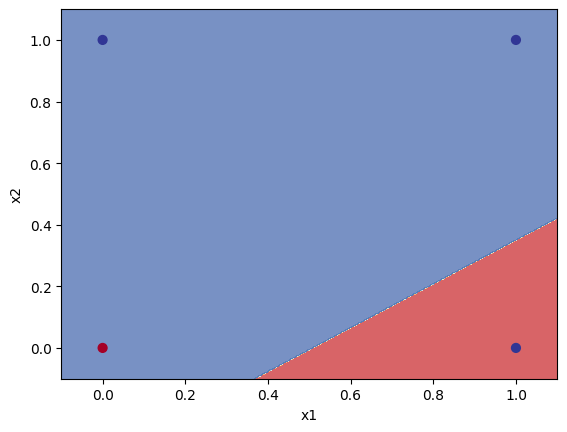

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5000 - loss: 0.6074
Epoch 401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6070
Epoch 402/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6066
Epoch 403/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6062
Epoch 404/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6058
Epoch 405/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6054
Epoch 406/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6050
Epoch 407/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6047
Epoch 408/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6043
Epoch 409/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6039
Epoch 410/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6035
Epoch 411/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - ac

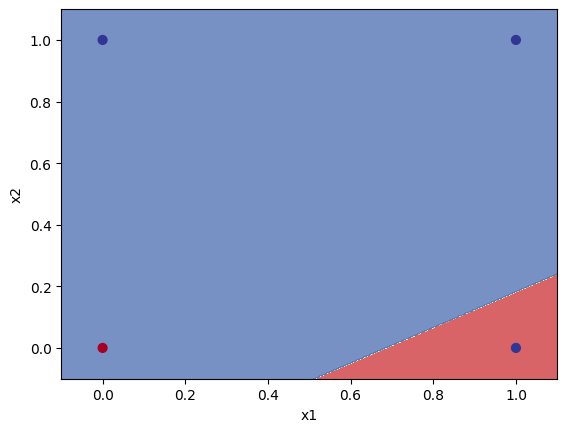

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5000 - loss: 0.5713
Epoch 501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.5710
Epoch 502/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.5707
Epoch 503/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.5703
Epoch 504/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.5700
Epoch 505/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.5697
Epoch 506/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5694
Epoch 507/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5691
Epoch 508/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.5687
Epoch 509/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.5684
Epoch 510/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.5681
Epoch 511/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

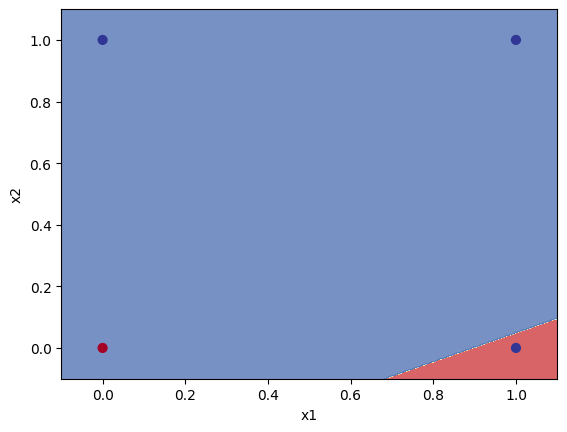

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5000 - loss: 0.5420
Epoch 601/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.5417
Epoch 602/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5414
Epoch 603/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5412
Epoch 604/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.5409
Epoch 605/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5407
Epoch 606/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5404
Epoch 607/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.5401
Epoch 608/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.5399
Epoch 609/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.5396
Epoch 610/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.5394
Epoch 611/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

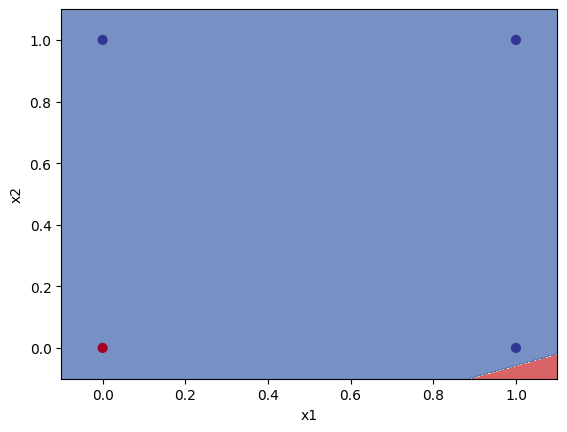

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7500 - loss: 0.5179
Epoch 701/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5177
Epoch 702/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5175
Epoch 703/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5173
Epoch 704/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5171
Epoch 705/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5168
Epoch 706/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5166
Epoch 707/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5164
Epoch 708/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5162
Epoch 709/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5160
Epoch 710/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5158
Epoch 711/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - ac

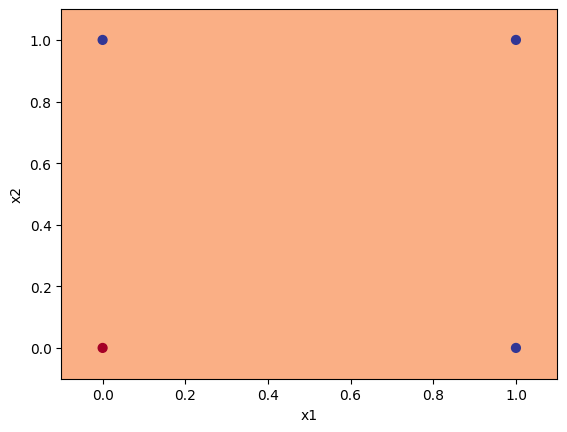

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7500 - loss: 0.4979
Epoch 801/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4978
Epoch 802/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.4976
Epoch 803/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4974
Epoch 804/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4972
Epoch 805/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4970
Epoch 806/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4968
Epoch 807/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4967
Epoch 808/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4965
Epoch 809/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4963
Epoch 810/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4961
Epoch 811/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - ac

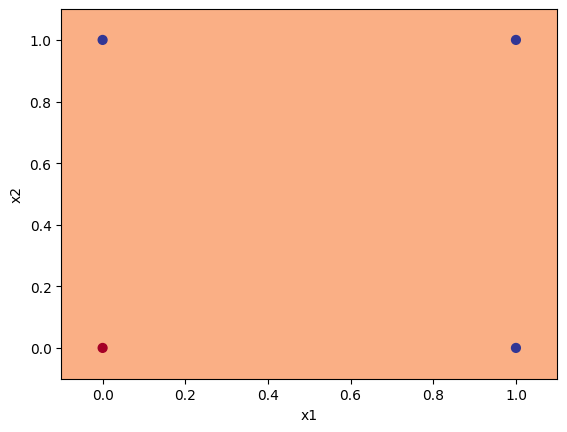

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7500 - loss: 0.4810
Epoch 901/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4808
Epoch 902/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4807
Epoch 903/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4805
Epoch 904/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4804
Epoch 905/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4802
Epoch 906/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4800
Epoch 907/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4799
Epoch 908/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4797
Epoch 909/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4796
Epoch 910/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4794
Epoch 911/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - ac

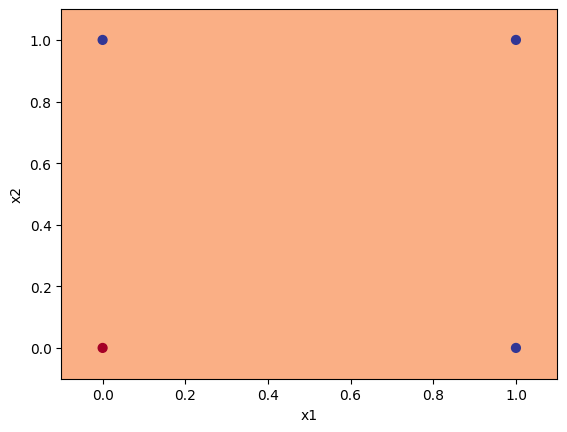

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7500 - loss: 0.4663
Epoch 1001/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4661
Epoch 1002/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4660
Epoch 1003/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4659
Epoch 1004/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4657
Epoch 1005/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4656
Epoch 1006/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4655
Epoch 1007/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4653
Epoch 1008/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4652
Epoch 1009/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4651
Epoch 1010/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4649
Epoch 1011/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

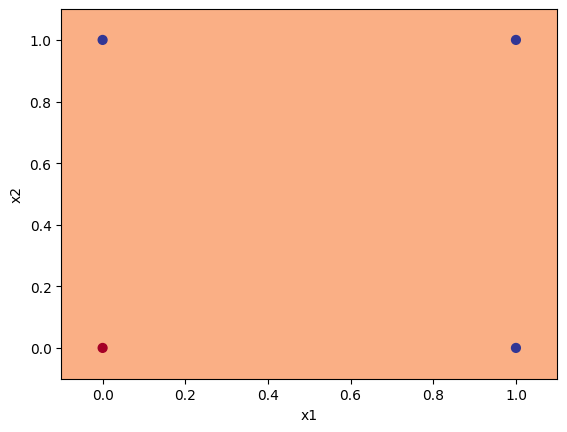

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7500 - loss: 0.4532
Epoch 1101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4531
Epoch 1102/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4530
Epoch 1103/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4528
Epoch 1104/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4527
Epoch 1105/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4526
Epoch 1106/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4525
Epoch 1107/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4524
Epoch 1108/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4522
Epoch 1109/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4521
Epoch 1110/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4520
Epoch 1111/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

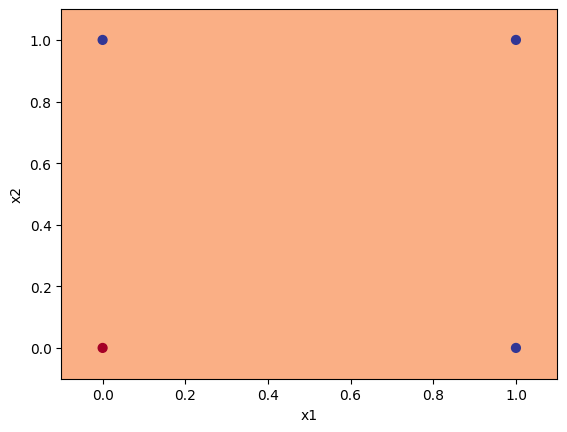

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7500 - loss: 0.4413
Epoch 1201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4412
Epoch 1202/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4411
Epoch 1203/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4410
Epoch 1204/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4409
Epoch 1205/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4407
Epoch 1206/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4406
Epoch 1207/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4405
Epoch 1208/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4404
Epoch 1209/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4403
Epoch 1210/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4402
Epoch 1211/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

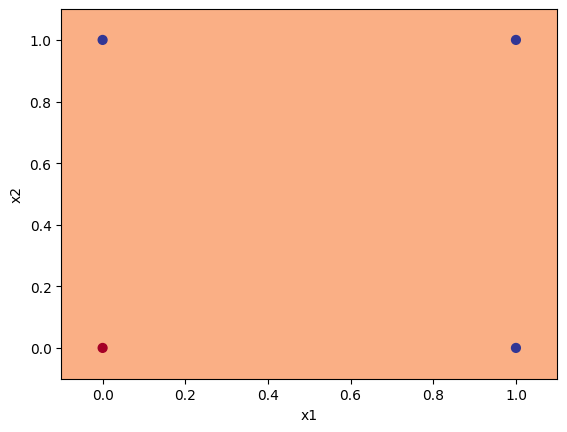

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7500 - loss: 0.4302
Epoch 1301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4301
Epoch 1302/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4300
Epoch 1303/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4299
Epoch 1304/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4298
Epoch 1305/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4297
Epoch 1306/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4296
Epoch 1307/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4294
Epoch 1308/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4293
Epoch 1309/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4292
Epoch 1310/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4291
Epoch 1311/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

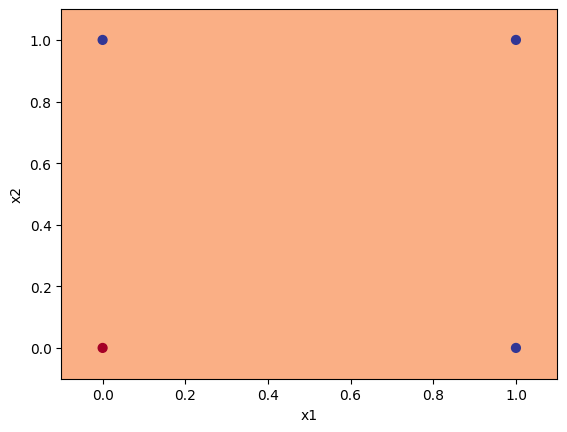

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7500 - loss: 0.4196
Epoch 1401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4195
Epoch 1402/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4194
Epoch 1403/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4193
Epoch 1404/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4192
Epoch 1405/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4191
Epoch 1406/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4190
Epoch 1407/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4189
Epoch 1408/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4188
Epoch 1409/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4187
Epoch 1410/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4186
Epoch 1411/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

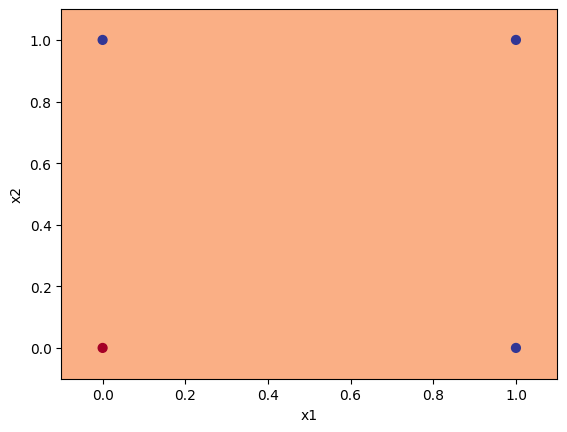

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7500 - loss: 0.4094
Epoch 1501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4093
Epoch 1502/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4092
Epoch 1503/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4091
Epoch 1504/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4090
Epoch 1505/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4089
Epoch 1506/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4088
Epoch 1507/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4087
Epoch 1508/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4086
Epoch 1509/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4085
Epoch 1510/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4084
Epoch 1511/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

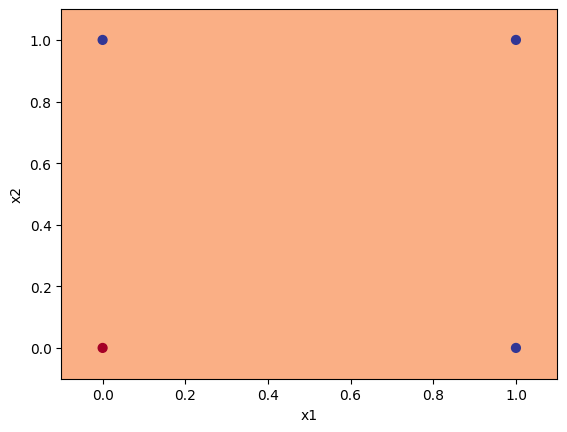

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7500 - loss: 0.3995
Epoch 1601/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3994
Epoch 1602/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3993
Epoch 1603/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3992
Epoch 1604/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.3991
Epoch 1605/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3990
Epoch 1606/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3989
Epoch 1607/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3988
Epoch 1608/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3987
Epoch 1609/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3986
Epoch 1610/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3985
Epoch 1611/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

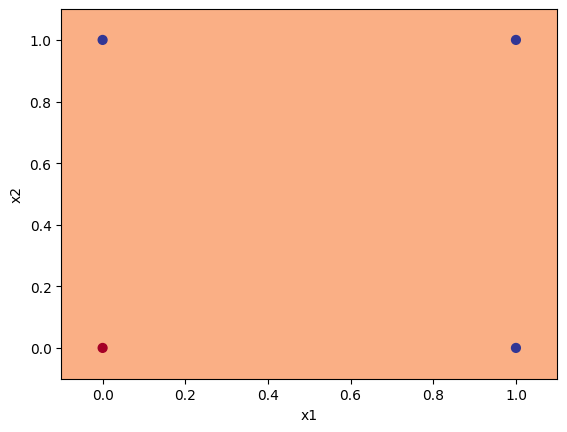

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7500 - loss: 0.3896
Epoch 1701/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3895
Epoch 1702/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3894
Epoch 1703/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3893
Epoch 1704/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3892
Epoch 1705/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3892
Epoch 1706/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3891
Epoch 1707/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3890
Epoch 1708/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3889
Epoch 1709/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3888
Epoch 1710/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3887
Epoch 1711/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

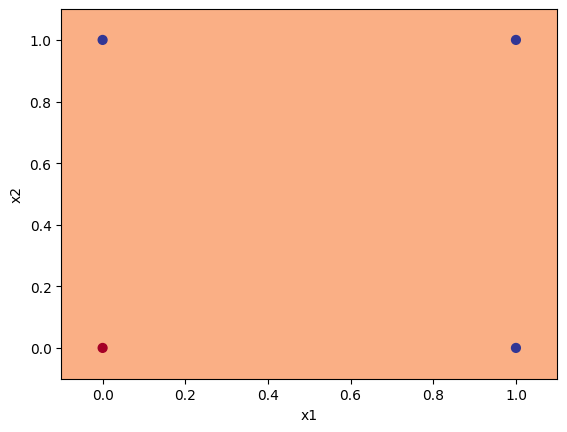

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7500 - loss: 0.3799
Epoch 1801/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3798
Epoch 1802/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3797
Epoch 1803/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3797
Epoch 1804/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3796
Epoch 1805/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3795
Epoch 1806/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3794
Epoch 1807/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3793
Epoch 1808/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3792
Epoch 1809/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3791
Epoch 1810/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3790
Epoch 1811/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

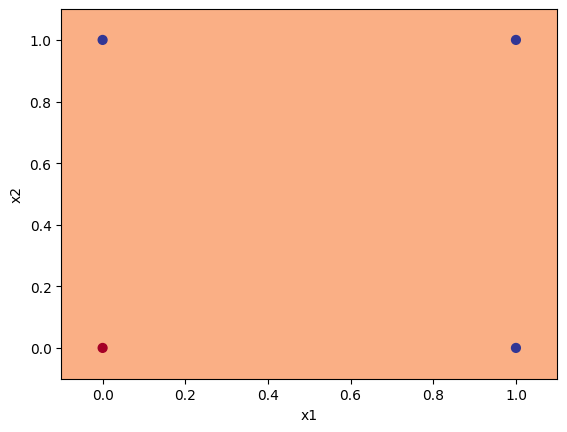

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7500 - loss: 0.3703
Epoch 1901/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3702
Epoch 1902/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3701
Epoch 1903/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3700
Epoch 1904/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3700
Epoch 1905/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3699
Epoch 1906/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3698
Epoch 1907/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3697
Epoch 1908/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3696
Epoch 1909/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3695
Epoch 1910/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3694
Epoch 1911/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

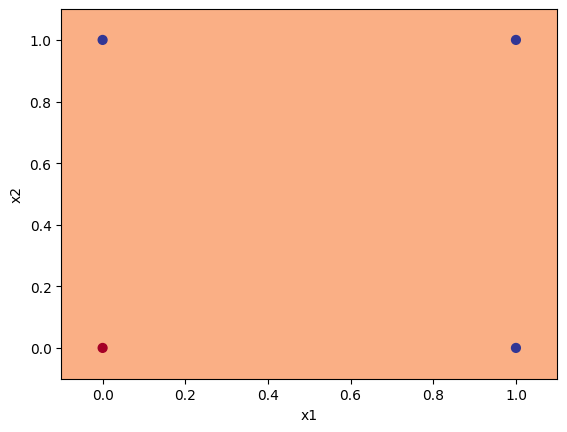

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7500 - loss: 0.3608
Epoch 2001/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3607
Epoch 2002/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3606
Epoch 2003/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3605
Epoch 2004/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3604
Epoch 2005/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3603
Epoch 2006/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3603
Epoch 2007/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3602
Epoch 2008/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3601
Epoch 2009/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3600
Epoch 2010/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3599
Epoch 2011/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

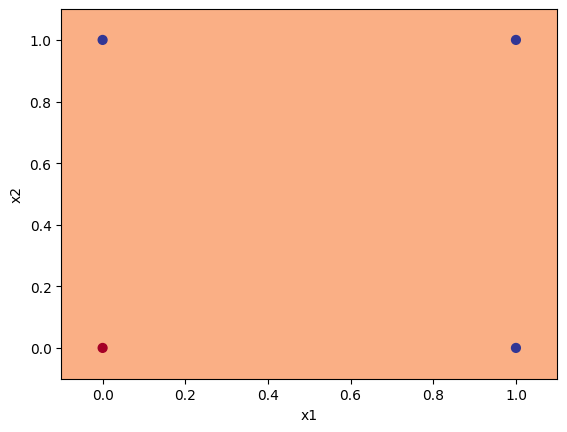

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7500 - loss: 0.3514
Epoch 2101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3513
Epoch 2102/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3512
Epoch 2103/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3511
Epoch 2104/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3510
Epoch 2105/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3509
Epoch 2106/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3508
Epoch 2107/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3507
Epoch 2108/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3506
Epoch 2109/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3506
Epoch 2110/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3505
Epoch 2111/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

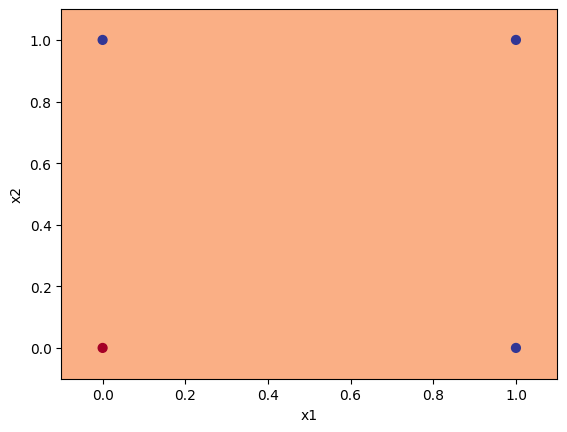

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7500 - loss: 0.3421
Epoch 2201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3420
Epoch 2202/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 0.3419
Epoch 2203/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3418
Epoch 2204/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.3417
Epoch 2205/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3416
Epoch 2206/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.3415
Epoch 2207/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3414
Epoch 2208/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.3413
Epoch 2209/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.3412
Epoch 2210/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3411
Epoch 2211/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

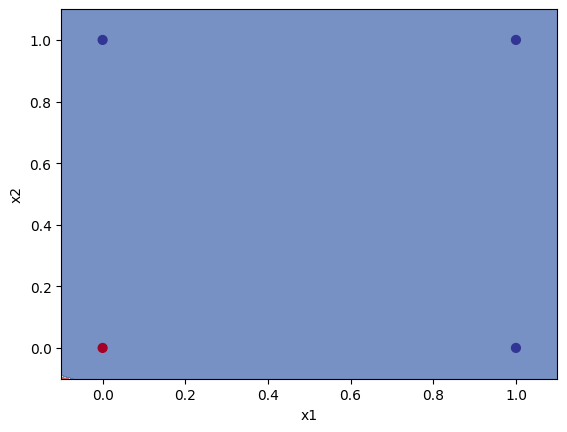

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7500 - loss: 0.3329
Epoch 2301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3328
Epoch 2302/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3327
Epoch 2303/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3326
Epoch 2304/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3325
Epoch 2305/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3324
Epoch 2306/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3323
Epoch 2307/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3322
Epoch 2308/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3321
Epoch 2309/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3320
Epoch 2310/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3320
Epoch 2311/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

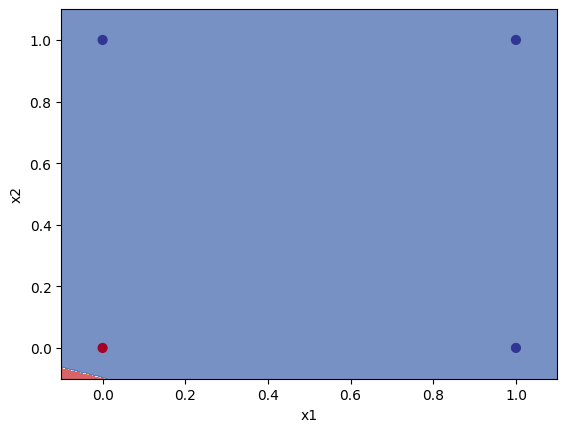

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7500 - loss: 0.3238
Epoch 2401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3237
Epoch 2402/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.3236
Epoch 2403/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3235
Epoch 2404/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3234
Epoch 2405/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3233
Epoch 2406/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3232
Epoch 2407/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3232
Epoch 2408/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3231
Epoch 2409/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3230
Epoch 2410/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3229
Epoch 2411/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

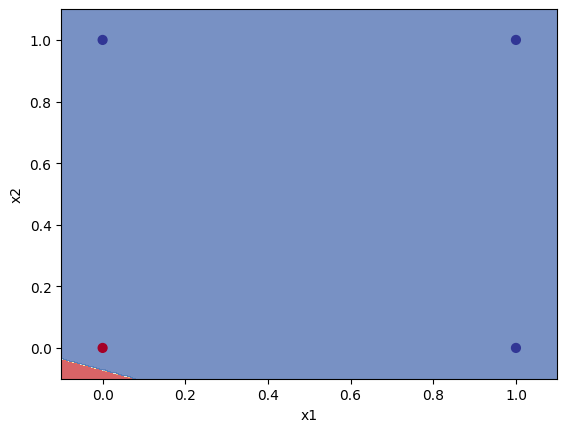

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7500 - loss: 0.3148
Epoch 2501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3148
Epoch 2502/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3147
Epoch 2503/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3146
Epoch 2504/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3145
Epoch 2505/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.3144
Epoch 2506/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3143
Epoch 2507/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3142
Epoch 2508/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3141
Epoch 2509/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3140
Epoch 2510/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3140
Epoch 2511/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

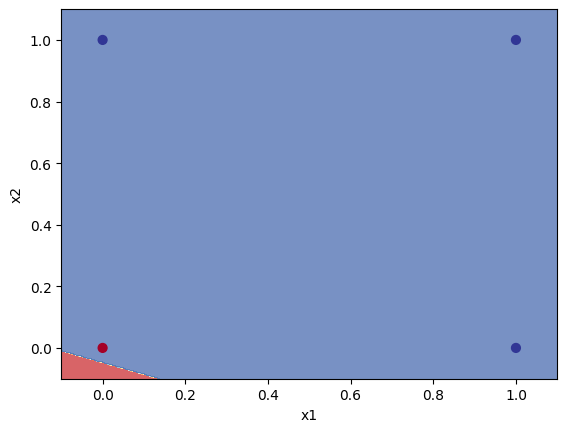

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7500 - loss: 0.3061
Epoch 2601/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.3060
Epoch 2602/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.3059
Epoch 2603/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3058
Epoch 2604/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.3057
Epoch 2605/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.3056
Epoch 2606/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3055
Epoch 2607/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3054
Epoch 2608/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3054
Epoch 2609/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.3053
Epoch 2610/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.3052
Epoch 2611/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

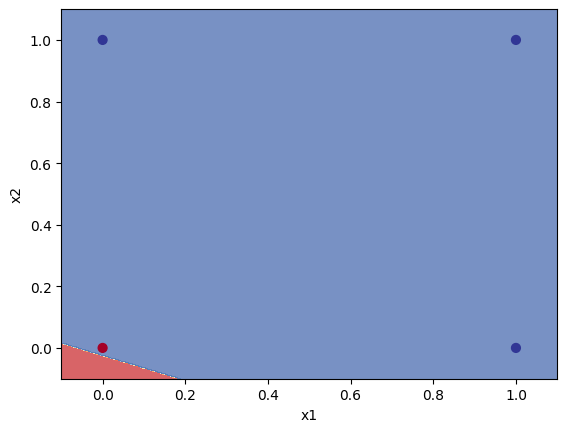

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7500 - loss: 0.2974
Epoch 2701/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.2973
Epoch 2702/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.2973
Epoch 2703/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.2972
Epoch 2704/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2971
Epoch 2705/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.2970
Epoch 2706/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2969
Epoch 2707/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2968
Epoch 2708/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.2967
Epoch 2709/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2967
Epoch 2710/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2966
Epoch 2711/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

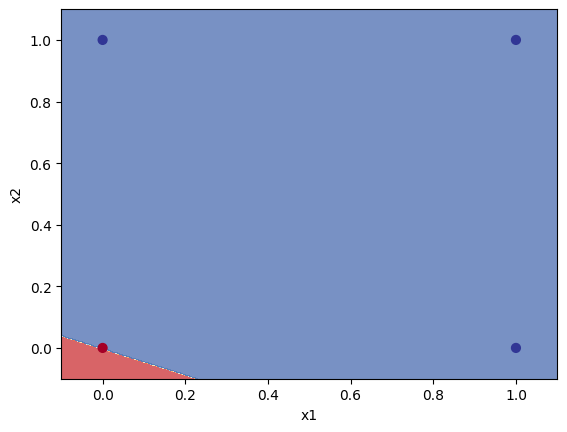

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7500 - loss: 0.2890
Epoch 2801/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.2889
Epoch 2802/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.2888
Epoch 2803/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2887
Epoch 2804/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.2886
Epoch 2805/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2885
Epoch 2806/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.2885
Epoch 2807/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.2884
Epoch 2808/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.2883
Epoch 2809/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.2882
Epoch 2810/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.2881
Epoch 2811/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

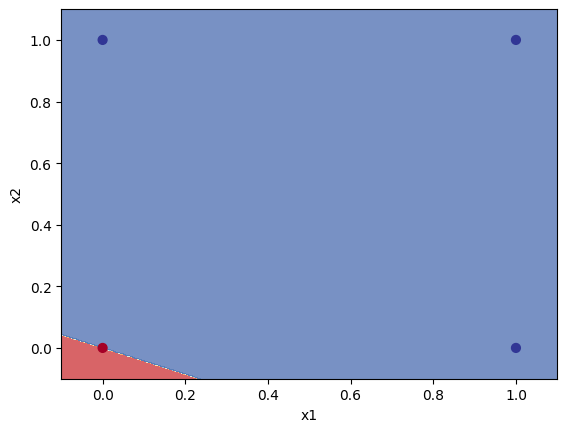

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 1.0000 - loss: 0.2876


In [36]:
model = trainModel(X, Y) # вызов обучения модели

In [37]:
input_data = np.array([[0, 1]])
testModel(input_data, model) # вызов тестирования обученной модели на тестовых данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.9066609]]


1

In [38]:
# Получить веса нейрона
model.get_weights()

[array([[0.971538],
        [2.274311]], dtype=float32),
 array([-0.00078129], dtype=float32)]